# Quantum Graph Transformer (QGT)

###  Classifying graphs with Quantum Neural Networks (QNNs)

We train QNNs for the purpose of classifying graphs.
We refer the resulting architecture: Quantum Graph Transformer (QGT) since it maintains the key archirectural elements of Graph Transformers (GTs). 

**Given a graph as input, our QGT will output the label 0 or 1 for it (binary classification task).**

In [1]:
from qiskit import *
from qiskit.circuit.library import GraphState, ZZFeatureMap, RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit.algorithms.optimizers import ADAM

import numpy as np
import networkx as nx
import matplotlib.pylab as plt
from sklearn.metrics import average_precision_score

## Generating data

We generate a graph dataset consisting of $k$ undirected, connected graphs $G_r(V_r, E_r)$ ($r=1,\ldots, k$) and assosiated binary class labels $l_r$. In what follows, a label is $0$ if the corresponding graph has not triangles and it is $1$ otherwise. We generate connected Watts–Strogatz small-world graphs for our experiments, all with the same number of nodes $n$. 

In [2]:
def generate_graph_dataset(num_nodes, 
                           num_graphs, 
                           k_nearest=2,
                           rewiring_probability=0.2):
        
    adjacency_array_list = []
    triangle_label_list  = []

    triangle_label_threshold = 1
    for _ in range(num_graphs):
    
        graph = nx.connected_watts_strogatz_graph(num_nodes, k_nearest, rewiring_probability)
        adjacency_array = nx.to_numpy_array(graph)
        adjacency_array_list.append(adjacency_array)
    
        triangles_dict = nx.triangles(graph)
        num_triangles = int(sum(triangles_dict.values()) / 3.0)
        triangle_label = 0
        if num_triangles >= triangle_label_threshold:
            triangle_label = 1
        triangle_label_list.append(triangle_label)
    return adjacency_array_list, triangle_label_list


## Building quantum circuits

In order to learn to classify graphs using QNNs we need to do two things:

- *Encode* graphs
- Allow for *learning parameters* that will optimize some cost function

We propose using quantum graph states https://en.wikipedia.org/wiki/Graph_state for representing our input graphs and use the associated *encoding circuit* for realizing them (`GraphState`: https://qiskit.org/documentation/stubs/qiskit.circuit.library.GraphState.html). 

For parameter learning we use a *variational circuit* 
(`RealAmplitudes`: https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html) (that provides placeholders for parameters to optimize). 

We compose our *encoding circuit* and *variational circuit* to build our quantum circuit. Our input quantum state over $n$ qubits (note, the number of qubits is equal to the number of nodes in each of the graphs) will be successively transformed by the *encoding circuit* and then by the "bound" *variational circuit* (i.e. with its parameters set to given values). 

In [3]:
def build_unbound_circuit(adjacency_array):
    num_qubits = adjacency_array.shape[0]
    
    encoding_circuit    = GraphState(adjacency_array)
    variational_circuit = RealAmplitudes(num_qubits, reps=1)
    circuit = encoding_circuit.compose(variational_circuit)
    
    return circuit, encoding_circuit, variational_circuit

In [4]:
def build_circuit(adjacency_array, parameters):
    circuit, encoding_circuit, variational_circuit = build_unbound_circuit(adjacency_array)
    
    parameters_dict = {}    
    for i, key in enumerate(variational_circuit.ordered_parameters):
        parameters_dict[key] = parameters[i]
    circuit = circuit.assign_parameters(parameters_dict)
    
    return circuit 

## Output quantum measurement to classification probabilities

The output state will be measured resulting to $2^n$ probabilities (for landing to each of the $2^n$ output configurations). An output configuration is a binary string label (e.g. '100101' for $n=6$): we choose to compute the *parity* of this label (being either $0$ or $1$) and agree on accumulating its probability on class label $0$ or $1$. So the probabilities of all output configurations with *parity* $0$ are added together and their sum is considered to be the probability of getting *classification* label $0$ (i.e. no triangles in the input graph).  

In [5]:
def measurement_probs(adjacency_array, parameters):
    num_qubits = adjacency_array.shape[0]
    
    state_vector = Statevector.from_label('0' * num_qubits)
    circuit = build_circuit(adjacency_array, parameters)
    circuit = state_vector.evolve(circuit)
    measurement_probabilities_dict = circuit.probabilities_dict()
    
    return measurement_probabilities_dict

In [6]:
def classification_probs(measurement_probabilities_dict):
    
    classification_probabilities_dict = {0 : 0.0, 1 : 0.0}
    
    for key, value in measurement_probabilities_dict.items():
        label = sum([int(bit) for bit in key]) & 1
        classification_probabilities_dict[label] += value
    
    return classification_probabilities_dict 

## Loss function

For a given graph and set of parameters, we compute the negative log loss for the predicted classification probabilities against the true classification label. We average these (binary cross entropy) loss terms over *all* our graphs and true classification labels: *this will be the value of our loss function for the given parameters*.

In [7]:
def negative_log_loss_term(probabilities_dict, true_label):
    term = - np.log(probabilities_dict[true_label])
    return term

In [8]:
def data_loss_func(adjacency_array_list, triangle_label_list, parameters, verbose=True, log=None):
    num_samples = len(adjacency_array_list)
    
    loss = 0.0
    for adjacency_array, triangle_label in zip(*[adjacency_array_list, triangle_label_list]):
        measurement_probabilities_dict    = measurement_probs(adjacency_array, parameters)
        classification_probabilities_dict = classification_probs(measurement_probabilities_dict)
        loss_term = negative_log_loss_term(classification_probabilities_dict, triangle_label)
        loss += loss_term
    loss = loss / num_samples
    
    if verbose:
        print(loss)  
    
    if log is not None:
        log.append(loss)
    
    return loss

## Experiment setup

For a graph dataset we generate, we initialize the parameters of our *variational circuit* with random values.

In [9]:
num_nodes            = 6
num_graphs           = 20
k_nearest            = 2
rewiring_probability = 0.2

adjacency_array_list, triangle_label_list = generate_graph_dataset(num_nodes, 
                                                                   num_graphs, 
                                                                   k_nearest, 
                                                                   rewiring_probability)


initial_parameters = 2.0 * np.pi * np.random.rand(2 * num_nodes)

log_list = []
loss_func = lambda parameters: data_loss_func(adjacency_array_list, 
                                              triangle_label_list, 
                                              parameters, 
                                              verbose=False,
                                              log=log_list)

### *Encoding circuit* for one of the input graphs

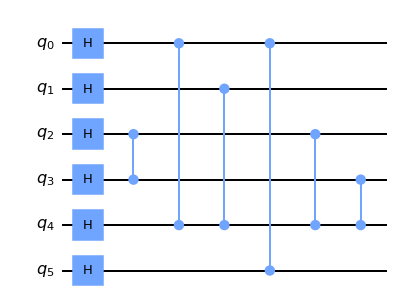

In [10]:
adjacency_array  = adjacency_array_list[0]
encoding_circuit = GraphState(adjacency_array)
encoding_circuit.decompose().draw(output='mpl')

### *Variational circuit*

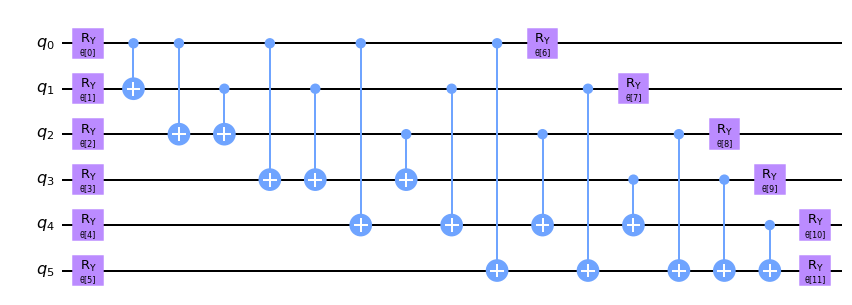

In [11]:
variational_circuit = RealAmplitudes(num_nodes, reps=1)
variational_circuit.decompose().draw(output='mpl')

### Graph dataset

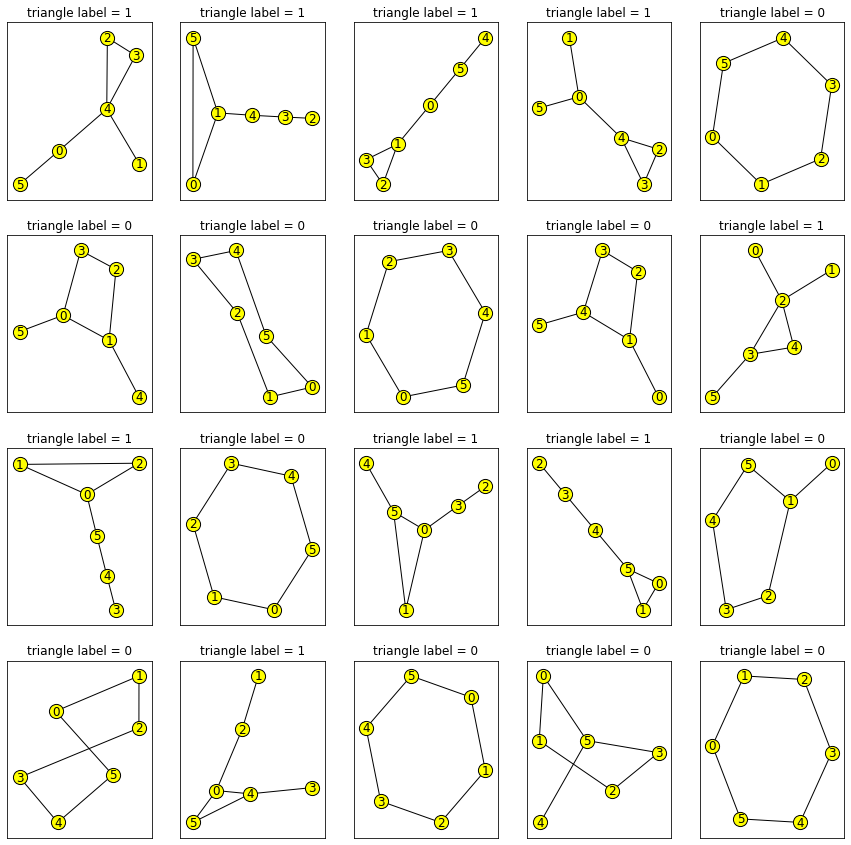

In [12]:
fig, ax = plt.subplots(4, 5, figsize=(15, 15)) # note: the number of graphs is 20 in this example

for i in range(num_graphs):
    
    adjacency_array = adjacency_array_list[i]
    triangle_label  = triangle_label_list[i]
    
    graph = nx.from_numpy_array(adjacency_array, create_using=nx.Graph)
    pos = nx.spring_layout(graph)
    
    row = i // 5
    col = i % 5

    nx.draw_networkx_nodes(graph,  pos, ax=ax[row, col], 
                       node_color='yellow', 
                       edgecolors='black', 
                       node_size=200);
    nx.draw_networkx_labels(graph, pos, ax=ax[row, col]);
    nx.draw_networkx_edges(graph,  pos, ax=ax[row, col]);
    ax[row, col].set_title('triangle label = {}'.format(triangle_label))

We leverage the Adam optimizer (ADAM: https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.ADAM.html) in order to learn parameters that will minimize the loss function value.

In [13]:
%%time
optimizer = ADAM(maxiter=50,
                 tol=1e-03,
                 lr=0.01,
                 amsgrad=True)

num_parameters = len(initial_parameters)
optimized_parameters, loss_func_value, _ = optimizer.optimize(num_parameters, 
                                                              loss_func, 
                                                              initial_point=initial_parameters)

CPU times: user 1min 34s, sys: 307 ms, total: 1min 34s
Wall time: 1min 34s


## Results

### Loss values

During training we record the evolution of (training) loss values across iterations

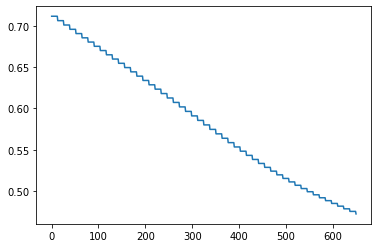

In [14]:
plt.plot(log_list);

Here are the initial and the learnt ("optimized") parameters for our *variational circuit*.

In [15]:
initial_parameters

array([2.49495945, 1.13995944, 1.59879746, 2.9439823 , 2.0416771 ,
       6.21998632, 5.37156644, 2.13172804, 3.58032315, 4.29091027,
       5.32333957, 4.55231188])

In [16]:
optimized_parameters

array([2.86580205, 1.60897299, 1.54495842, 3.29882591, 2.10247687,
       5.80345933, 4.98301771, 1.62435088, 4.12457228, 3.78643487,
       5.5815091 , 4.15289424])

### Average precision score

We can now supply these two sets of parameters to our circuit, for all graphs, and compute for each set the *average precision score*.

In [17]:
initial_classification_probs_list   = [classification_probs(measurement_probs(adjacency_array, initial_parameters)) 
                                       for adjacency_array in adjacency_array_list]

optimized_classification_probs_list = [classification_probs(measurement_probs(adjacency_array, optimized_parameters))
                                       for adjacency_array in adjacency_array_list]

initial_positive_prediction_probs   = [x[1] for x in initial_classification_probs_list]
optimized_positive_prediction_probs = [x[1] for x in optimized_classification_probs_list]

In [18]:
average_precision_score(triangle_label_list, initial_positive_prediction_probs)

0.5002867502867503

In [19]:
average_precision_score(triangle_label_list, optimized_positive_prediction_probs)

0.9598765432098768

***We get an improvement, for this single run, as reasonably expected.***